**Cell 1: Mount Google Drive and Unzip Dataset**

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip the dataset
!unzip "/content/drive/My Drive/fish_project/fish_image.zip" -d "/content/"

# Define the path to the unzipped dataset folder
dataset_path = '/content/fish_image/'  # Path after unzipping

# Check if the unzipped folder exists
import os  # Import os for path checks
if os.path.exists(dataset_path):
    print("Dataset unzipped successfully. Using path:", dataset_path)
else:
    print("Unzipping failed or folder name mismatch. Check the unzip output above and adjust 'dataset_path'.")
    dataset_path = None  # Set to None to avoid errors

Streaming output truncated to the last 5000 lines.
  inflating: /content/fish_image/fish_04/fish_004604697458_25086.png  
  inflating: /content/fish_image/fish_04/fish_004604757458_08968.png  
  inflating: /content/fish_image/fish_04/fish_004604757458_08970.png  
  inflating: /content/fish_image/fish_04/fish_004604757458_09078.png  
  inflating: /content/fish_image/fish_04/fish_004604757458_10222.png  
  inflating: /content/fish_image/fish_04/fish_004604757458_11090.png  
  inflating: /content/fish_image/fish_04/fish_004604757458_15432.png  
  inflating: /content/fish_image/fish_04/fish_004604837458_09077.png  
  inflating: /content/fish_image/fish_04/fish_004604857458_17760.png  
  inflating: /content/fish_image/fish_04/fish_004604887458_11726.png  
  inflating: /content/fish_image/fish_04/fish_004604887458_17623.png  
  inflating: /content/fish_image/fish_04/fish_004604887458_21280.png  
  inflating: /content/fish_image/fish_04/fish_004604897458_23260.png  
  inflating: /content/fish

**Cell 2: Import Libraries**

In [2]:
# Import necessary libraries for image processing, machine learning, and deep learning
import os  # For file path operations
import cv2  # OpenCV for image processing
import numpy as np  # For numerical operations and arrays
from sklearn.model_selection import train_test_split  # To split data into train/test
from sklearn.preprocessing import StandardScaler, LabelEncoder  # For scaling and encoding
from sklearn.neural_network import MLPClassifier  # ANN (Multi-Layer Perceptron)
from sklearn.svm import SVC  # SVM classifier
from sklearn.neighbors import KNeighborsClassifier  # KNN classifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score  # For evaluation metrics
import matplotlib.pyplot as plt  # For plotting confusion matrices
import seaborn as sns  # For better confusion matrix visualization
from tensorflow.keras.models import Sequential  # For building CNN models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # CNN layers
from tensorflow.keras.utils import to_categorical  # For one-hot encoding labels
from skimage import feature  # For LBP
from skimage.feature import graycomatrix, graycoprops  # For GLCM

In [3]:
# ============================================
# NEW CELL: Selective Sampling and Augmentation
# ============================================

import os
import cv2
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Selected classes and target sample counts
selected_classes = {
    "fish_01": 2500,
    "fish_02": 2500,
    "fish_03": 2500,
    "fish_04": 2500,
    "fish_05": 2500,
    "fish_07": 1000
}

fish_root = "/content/fish_image"         # original image folder
mask_root = "/content/mask_image"         # original mask folder (if segmentation masks exist)

augmented_root = "/content/fish_augmented"
augmented_mask_root = "/content/mask_augmented"

os.makedirs(augmented_root, exist_ok=True)
os.makedirs(augmented_mask_root, exist_ok=True)

# Augmentation generator for images
img_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Augmentation generator for masks (no color changes)
mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)


def augment_sample(image, mask=None):
    """Apply identical augmentation to image and mask."""
    seed = np.random.randint(0, 999999)

    img_aug = img_datagen.random_transform(image, seed=seed)

    if mask is not None:
        mask_aug = mask_datagen.random_transform(mask, seed=seed)
    else:
        mask_aug = None

    return img_aug, mask_aug


print("Starting selective sampling and augmentation...")

# Process each selected folder
for cls, target_count in selected_classes.items():
    print(f"Processing {cls} (target {target_count})")

    class_img_dir = os.path.join(fish_root, cls)
    class_mask_dir = os.path.join(mask_root, cls) if os.path.exists(mask_root) else None

    save_img_dir = os.path.join(augmented_root, cls)
    save_mask_dir = os.path.join(augmented_mask_root, cls)

    os.makedirs(save_img_dir, exist_ok=True)
    if class_mask_dir:
        os.makedirs(save_mask_dir, exist_ok=True)

    image_files = sorted(os.listdir(class_img_dir))
    current_images = []

    # Load images and masks
    for filename in image_files:
        img_path = os.path.join(class_img_dir, filename)
        img = cv2.imread(img_path)

        if img is None:
            continue

        if class_mask_dir:
            mask_path = os.path.join(class_mask_dir, filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            mask = None

        current_images.append((img, mask))

    # Case 1: Enough images exist → sample directly
    if len(current_images) >= target_count:
        selected_samples = random.sample(current_images, target_count)
    else:
        selected_samples = current_images.copy()

    # Save originals first
    idx = 0
    for img, mask in selected_samples:
        cv2.imwrite(os.path.join(save_img_dir, f"{cls}_{idx}.png"), img)
        if mask is not None:
            cv2.imwrite(os.path.join(save_mask_dir, f"{cls}_{idx}.png"), mask)
        idx += 1

    # Case 2: Not enough images → augment until target reached
    while idx < target_count:
        src_img, src_mask = random.choice(current_images)
        aug_img, aug_mask = augment_sample(src_img, src_mask)

        cv2.imwrite(os.path.join(save_img_dir, f"{cls}_{idx}.png"), aug_img)
        if aug_mask is not None:
            cv2.imwrite(os.path.join(save_mask_dir, f"{cls}_{idx}.png"), aug_mask)

        idx += 1

    print(f"Completed {cls}: final count {idx}")

print("Augmentation finished.")


Starting selective sampling and augmentation...
Processing fish_01 (target 2500)
Completed fish_01: final count 2500
Processing fish_02 (target 2500)
Completed fish_02: final count 2500
Processing fish_03 (target 2500)
Completed fish_03: final count 2500
Processing fish_04 (target 2500)
Completed fish_04: final count 2500
Processing fish_05 (target 2500)
Completed fish_05: final count 2500
Processing fish_07 (target 1000)
Completed fish_07: final count 1000
Augmentation finished.


**Cell 3: Load and Preprocess Dataset**

In [7]:
# ============================================
# Cell 3: Load and Preprocess Dataset
# Using augmented dataset only
# ============================================

# Updated dataset path (augmented images)
dataset_path = '/content/fish_augmented/'

# Optional: if you will use segmentation later
# mask_dataset_path = '/content/mask_augmented/'

# Path to save/load preprocessed data
save_path = '/content/dataset_preprocessed.npz'

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# If preprocessed data exists, load it directly
if os.path.exists(save_path):
    print("Loading preprocessed data from saved file...")
    data = np.load(save_path, allow_pickle=True)

    X_train = data['X_train']
    X_test = data['X_test']
    y_train_encoded = data['y_train_encoded']
    y_test_encoded = data['y_test_encoded']
    X_train_cnn = data['X_train_cnn']
    X_test_cnn = data['X_test_cnn']
    y_train_cnn = data['y_train_cnn']
    y_test_cnn = data['y_test_cnn']
    le = data['le'].item()

    print(f"Loaded {len(X_train)} train images and {len(X_test)} test images from {len(le.classes_)} classes.")

else:
    # Check dataset folder
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset folder '{dataset_path}' not found.")
        raise SystemExit

    # Function to load images and labels
    def load_images_from_folder(folder):
        images = []
        labels = []

        class_names = sorted(os.listdir(folder))

        for class_name in class_names:
            class_path = os.path.join(folder, class_name)

            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    img = cv2.imread(img_path)

                    if img is not None:
                        img = cv2.resize(img, (64, 64))   # resize to 64x64
                        images.append(img)
                        labels.append(class_name)

        return np.array(images), np.array(labels)

    # Load data
    X_all, y_all = load_images_from_folder(dataset_path)

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    )

    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Normalize for CNN
    X_train_cnn = X_train.astype('float32') / 255.0
    X_test_cnn = X_test.astype('float32') / 255.0

    y_train_cnn = to_categorical(y_train_encoded)
    y_test_cnn = to_categorical(y_test_encoded)

    # Save preprocessed dataset
    np.savez(
        save_path,
        X_train=X_train,
        X_test=X_test,
        y_train_encoded=y_train_encoded,
        y_test_encoded=y_test_encoded,
        X_train_cnn=X_train_cnn,
        X_test_cnn=X_test_cnn,
        y_train_cnn=y_train_cnn,
        y_test_cnn=y_test_cnn,
        le=le
    )

    print(f"Preprocessed data saved to {save_path}. Loaded {len(X_train)} train images and {len(X_test)} test images from {len(le.classes_)} classes.")


Preprocessed data saved to /content/dataset_preprocessed.npz. Loaded 10800 train images and 2700 test images from 6 classes.


In [20]:
# ============================================
# Cell A: LBP Features + Grid-Search KNN/SVM + ANN (10 epochs per fold)
# ============================================

import time
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from skimage import feature
import cv2

# -------- LBP Feature Extraction --------
def extract_lbp_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = feature.local_binary_pattern(gray, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return np.array(features)

X_train_lbp = extract_lbp_features(X_train)
X_test_lbp = extract_lbp_features(X_test)

scaler_lbp = StandardScaler()
X_train_lbp_scaled = scaler_lbp.fit_transform(X_train_lbp)
X_test_lbp_scaled = scaler_lbp.transform(X_test_lbp)

# -------- ANN Builder (Keras) --------
def build_ann(input_dim, output_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

y_train_ohe = to_categorical(y_train_encoded, num_classes=len(le.classes_))

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# ==========================
# 1) Grid Search for LBP + KNN
# ==========================
knn_metrics = ['euclidean', 'manhattan']
knn_mean_acc = {}
knn_mean_time = {}

print("LBP: Grid search for KNN metrics")

for metric in knn_metrics:
    fold_acc = []
    fold_time = []
    print(f"  Testing KNN metric = {metric}")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_lbp_scaled, y_train_encoded), 1):
        X_tr, X_val = X_train_lbp_scaled[train_idx], X_train_lbp_scaled[val_idx]
        y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

        start = time.time()
        knn_model = KNeighborsClassifier(n_neighbors=5, metric=metric)
        knn_model.fit(X_tr, y_tr)
        pred = knn_model.predict(X_val)
        end = time.time()

        acc = accuracy_score(y_val, pred)
        fold_acc.append(acc)
        fold_time.append(end - start)

        print(f"    Fold {fold}/{k_folds}: acc={acc:.4f}, time={end - start:.3f}s")

    knn_mean_acc[metric] = np.mean(fold_acc)
    knn_mean_time[metric] = np.mean(fold_time)
    print(f"  Metric {metric}: mean acc={knn_mean_acc[metric]:.4f}, mean time={knn_mean_time[metric]:.3f}s")

best_knn_metric_lbp = max(knn_mean_acc, key=knn_mean_acc.get)
print(f"Best LBP+KNN metric: {best_knn_metric_lbp} (mean acc={knn_mean_acc[best_knn_metric_lbp]:.4f})")

# Train final KNN with best metric
knn_lbp = KNeighborsClassifier(n_neighbors=5, metric=best_knn_metric_lbp)
knn_lbp.fit(X_train_lbp_scaled, y_train_encoded)
y_pred_lbp_knn = knn_lbp.predict(X_test_lbp_scaled)

# ==========================
# 2) Grid Search for LBP + SVM
# ==========================
svm_kernels = ['linear', 'rbf', 'poly']
svm_mean_acc = {}
svm_mean_time = {}

print("\nLBP: Grid search for SVM kernels")

for kernel in svm_kernels:
    fold_acc = []
    fold_time = []
    print(f"  Testing SVM kernel = {kernel}")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_lbp_scaled, y_train_encoded), 1):
        X_tr, X_val = X_train_lbp_scaled[train_idx], X_train_lbp_scaled[val_idx]
        y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

        start = time.time()
        svm_model = SVC(kernel=kernel)
        svm_model.fit(X_tr, y_tr)
        pred = svm_model.predict(X_val)
        end = time.time()

        acc = accuracy_score(y_val, pred)
        fold_acc.append(acc)
        fold_time.append(end - start)

        print(f"    Fold {fold}/{k_folds}: acc={acc:.4f}, time={end - start:.3f}s")

    svm_mean_acc[kernel] = np.mean(fold_acc)
    svm_mean_time[kernel] = np.mean(fold_time)
    print(f"  Kernel {kernel}: mean acc={svm_mean_acc[kernel]:.4f}, mean time={svm_mean_time[kernel]:.3f}s")

best_svm_kernel_lbp = max(svm_mean_acc, key=svm_mean_acc.get)
print(f"Best LBP+SVM kernel: {best_svm_kernel_lbp} (mean acc={svm_mean_acc[best_svm_kernel_lbp]:.4f})")

# Train final SVM with best kernel
svm_lbp = SVC(kernel=best_svm_kernel_lbp)
svm_lbp.fit(X_train_lbp_scaled, y_train_encoded)
y_pred_lbp_svm = svm_lbp.predict(X_test_lbp_scaled)

# ==========================
# 3) LBP + ANN (Keras, 10 epochs per fold)
# ==========================
ann_fold_acc = []
ann_fold_time = []

print("\nLBP: Cross-validation for ANN (10 epochs per fold)")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_lbp_scaled, y_train_encoded), 1):
    X_tr, X_val = X_train_lbp_scaled[train_idx], X_train_lbp_scaled[val_idx]
    y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

    y_tr_ohe = to_categorical(y_tr, num_classes=len(le.classes_))

    ann_model = build_ann(input_dim=X_train_lbp_scaled.shape[1], output_dim=len(le.classes_))

    start = time.time()
    ann_model.fit(X_tr, y_tr_ohe, epochs=10, batch_size=32, verbose=0)
    preds_val = ann_model.predict(X_val)
    end = time.time()

    preds_val_labels = np.argmax(preds_val, axis=1)
    acc = accuracy_score(y_val, preds_val_labels)

    ann_fold_acc.append(acc)
    ann_fold_time.append(end - start)

    print(f"  Fold {fold}/{k_folds}: acc={acc:.4f}, time={end - start:.3f}s")

print(f"LBP+ANN: mean acc={np.mean(ann_fold_acc):.4f}, mean time per fold={np.mean(ann_fold_time):.3f}s")

# Train final ANN on all LBP training data
ann_lbp = build_ann(input_dim=X_train_lbp_scaled.shape[1], output_dim=len(le.classes_))
ann_lbp.fit(X_train_lbp_scaled, y_train_ohe, epochs=10, batch_size=32, verbose=0)
y_pred_lbp_ann = np.argmax(ann_lbp.predict(X_test_lbp_scaled), axis=1)

print("LBP models (KNN/SVM/ANN) training completed.")


LBP: Grid search for KNN metrics
  Testing KNN metric = euclidean
    Fold 1/5: acc=0.5875, time=0.091s
    Fold 2/5: acc=0.5787, time=0.078s
    Fold 3/5: acc=0.5884, time=0.078s
    Fold 4/5: acc=0.5810, time=0.080s
    Fold 5/5: acc=0.5755, time=0.076s
  Metric euclidean: mean acc=0.5822, mean time=0.081s
  Testing KNN metric = manhattan
    Fold 1/5: acc=0.5866, time=0.144s
    Fold 2/5: acc=0.5718, time=0.142s
    Fold 3/5: acc=0.5801, time=0.146s
    Fold 4/5: acc=0.5806, time=0.143s
    Fold 5/5: acc=0.5773, time=0.164s
  Metric manhattan: mean acc=0.5793, mean time=0.148s
Best LBP+KNN metric: euclidean (mean acc=0.5822)

LBP: Grid search for SVM kernels
  Testing SVM kernel = linear
    Fold 1/5: acc=0.5917, time=4.059s
    Fold 2/5: acc=0.5769, time=2.957s
    Fold 3/5: acc=0.5667, time=2.998s
    Fold 4/5: acc=0.5681, time=3.077s
    Fold 5/5: acc=0.5847, time=7.630s
  Kernel linear: mean acc=0.5776, mean time=4.144s
  Testing SVM kernel = rbf
    Fold 1/5: acc=0.6435, time=3

In [21]:
# ============================================
# Cell B: GLCM Features + Grid-Search KNN/SVM + ANN (10 epochs per fold)
# ============================================

import time
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from skimage.feature import graycomatrix, graycoprops
import cv2

# -------- GLCM Feature Extraction --------
def extract_glcm_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(
            gray,
            distances=[1],
            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
            levels=256,
            symmetric=True,
            normed=True
        )
        contrast = graycoprops(glcm, 'contrast').ravel()
        dissimilarity = graycoprops(glcm, 'dissimilarity').ravel()
        homogeneity = graycoprops(glcm, 'homogeneity').ravel()
        energy = graycoprops(glcm, 'energy').ravel()
        correlation = graycoprops(glcm, 'correlation').ravel()
        feature_vector = np.concatenate(
            [contrast, dissimilarity, homogeneity, energy, correlation]
        )
        features.append(feature_vector)
    return np.array(features)

X_train_glcm = extract_glcm_features(X_train)
X_test_glcm = extract_glcm_features(X_test)

scaler_glcm = StandardScaler()
X_train_glcm_scaled = scaler_glcm.fit_transform(X_train_glcm)
X_test_glcm_scaled = scaler_glcm.transform(X_test_glcm)

# Reuse same ANN builder
def build_ann(input_dim, output_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

y_train_ohe_glcm = to_categorical(y_train_encoded, num_classes=len(le.classes_))

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# ==========================
# 1) Grid Search for GLCM + KNN
# ==========================
knn_metrics = ['euclidean', 'manhattan']
knn_mean_acc_glcm = {}
knn_mean_time_glcm = {}

print("GLCM: Grid search for KNN metrics")

for metric in knn_metrics:
    fold_acc = []
    fold_time = []
    print(f"  Testing KNN metric = {metric}")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_glcm_scaled, y_train_encoded), 1):
        X_tr, X_val = X_train_glcm_scaled[train_idx], X_train_glcm_scaled[val_idx]
        y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

        start = time.time()
        knn_model = KNeighborsClassifier(n_neighbors=5, metric=metric)
        knn_model.fit(X_tr, y_tr)
        pred = knn_model.predict(X_val)
        end = time.time()

        acc = accuracy_score(y_val, pred)
        fold_acc.append(acc)
        fold_time.append(end - start)

        print(f"    Fold {fold}/{k_folds}: acc={acc:.4f}, time={end - start:.3f}s")

    knn_mean_acc_glcm[metric] = np.mean(fold_acc)
    knn_mean_time_glcm[metric] = np.mean(fold_time)
    print(f"  Metric {metric}: mean acc={knn_mean_acc_glcm[metric]:.4f}, mean time={knn_mean_time_glcm[metric]:.3f}s")

best_knn_metric_glcm = max(knn_mean_acc_glcm, key=knn_mean_acc_glcm.get)
print(f"Best GLCM+KNN metric: {best_knn_metric_glcm} (mean acc={knn_mean_acc_glcm[best_knn_metric_glcm]:.4f})")

knn_glcm = KNeighborsClassifier(n_neighbors=5, metric=best_knn_metric_glcm)
knn_glcm.fit(X_train_glcm_scaled, y_train_encoded)
y_pred_glcm_knn = knn_glcm.predict(X_test_glcm_scaled)

# ==========================
# 2) Grid Search for GLCM + SVM
# ==========================
svm_kernels = ['linear', 'rbf', 'poly']
svm_mean_acc_glcm = {}
svm_mean_time_glcm = {}

print("\nGLCM: Grid search for SVM kernels")

for kernel in svm_kernels:
    fold_acc = []
    fold_time = []
    print(f"  Testing SVM kernel = {kernel}")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_glcm_scaled, y_train_encoded), 1):
        X_tr, X_val = X_train_glcm_scaled[train_idx], X_train_glcm_scaled[val_idx]
        y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

        start = time.time()
        svm_model = SVC(kernel=kernel)
        svm_model.fit(X_tr, y_tr)
        pred = svm_model.predict(X_val)
        end = time.time()

        acc = accuracy_score(y_val, pred)
        fold_acc.append(acc)
        fold_time.append(end - start)

        print(f"    Fold {fold}/{k_folds}: acc={acc:.4f}, time={end - start:.3f}s")

    svm_mean_acc_glcm[kernel] = np.mean(fold_acc)
    svm_mean_time_glcm[kernel] = np.mean(fold_time)
    print(f"  Kernel {kernel}: mean acc={svm_mean_acc_glcm[kernel]:.4f}, mean time={svm_mean_time_glcm[kernel]:.3f}s")

best_svm_kernel_glcm = max(svm_mean_acc_glcm, key=svm_mean_acc_glcm.get)
print(f"Best GLCM+SVM kernel: {best_svm_kernel_glcm} (mean acc={svm_mean_acc_glcm[best_svm_kernel_glcm]:.4f})")

svm_glcm = SVC(kernel=best_svm_kernel_glcm)
svm_glcm.fit(X_train_glcm_scaled, y_train_encoded)
y_pred_glcm_svm = svm_glcm.predict(X_test_glcm_scaled)

# ==========================
# 3) GLCM + ANN (Keras, 10 epochs per fold)
# ==========================
ann_fold_acc_glcm = []
ann_fold_time_glcm = []

print("\nGLCM: Cross-validation for ANN (10 epochs per fold)")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_glcm_scaled, y_train_encoded), 1):
    X_tr, X_val = X_train_glcm_scaled[train_idx], X_train_glcm_scaled[val_idx]
    y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

    y_tr_ohe = to_categorical(y_tr, num_classes=len(le.classes_))

    ann_model = build_ann(input_dim=X_train_glcm_scaled.shape[1], output_dim=len(le.classes_))

    start = time.time()
    ann_model.fit(X_tr, y_tr_ohe, epochs=10, batch_size=32, verbose=0)
    preds_val = ann_model.predict(X_val)
    end = time.time()

    preds_val_labels = np.argmax(preds_val, axis=1)
    acc = accuracy_score(y_val, preds_val_labels)

    ann_fold_acc_glcm.append(acc)
    ann_fold_time_glcm.append(end - start)

    print(f"  Fold {fold}/{k_folds}: acc={acc:.4f}, time={end - start:.3f}s")

print(f"GLCM+ANN: mean acc={np.mean(ann_fold_acc_glcm):.4f}, mean time per fold={np.mean(ann_fold_time_glcm):.3f}s")

ann_glcm = build_ann(input_dim=X_train_glcm_scaled.shape[1], output_dim=len(le.classes_))
ann_glcm.fit(X_train_glcm_scaled, y_train_ohe_glcm, epochs=10, batch_size=32, verbose=0)
y_pred_glcm_ann = np.argmax(ann_glcm.predict(X_test_glcm_scaled), axis=1)

print("GLCM models (KNN/SVM/ANN) training completed.")


GLCM: Grid search for KNN metrics
  Testing KNN metric = euclidean
    Fold 1/5: acc=0.7005, time=0.087s
    Fold 2/5: acc=0.6991, time=0.090s
    Fold 3/5: acc=0.7042, time=0.081s
    Fold 4/5: acc=0.7042, time=0.086s
    Fold 5/5: acc=0.7069, time=0.090s
  Metric euclidean: mean acc=0.7030, mean time=0.087s
  Testing KNN metric = manhattan
    Fold 1/5: acc=0.7083, time=0.365s
    Fold 2/5: acc=0.7009, time=0.355s
    Fold 3/5: acc=0.7125, time=0.357s
    Fold 4/5: acc=0.7130, time=0.367s
    Fold 5/5: acc=0.7162, time=0.359s
  Metric manhattan: mean acc=0.7102, mean time=0.361s
Best GLCM+KNN metric: manhattan (mean acc=0.7102)

GLCM: Grid search for SVM kernels
  Testing SVM kernel = linear
    Fold 1/5: acc=0.7194, time=2.800s
    Fold 2/5: acc=0.6926, time=2.714s
    Fold 3/5: acc=0.7185, time=3.774s
    Fold 4/5: acc=0.7153, time=2.686s
    Fold 5/5: acc=0.7009, time=2.648s
  Kernel linear: mean acc=0.7094, mean time=2.924s
  Testing SVM kernel = rbf
    Fold 1/5: acc=0.7190, tim

Classification Metrics for All Models:
   Model  Accuracy  Precision   Recall  F1-score
 LBP+KNN  0.586667   0.596733 0.586667  0.589972
 LBP+SVM  0.638889   0.645766 0.638889  0.640403
 LBP+ANN  0.635926   0.645808 0.635926  0.637093
GLCM+KNN  0.726296   0.728189 0.726296  0.726098
GLCM+SVM  0.726667   0.729521 0.726667  0.725656
GLCM+ANN  0.728148   0.737256 0.728148  0.728060


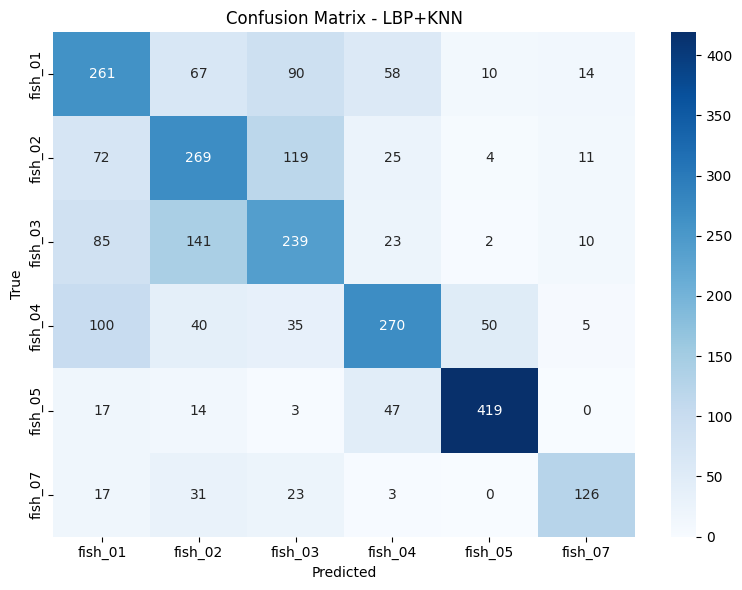

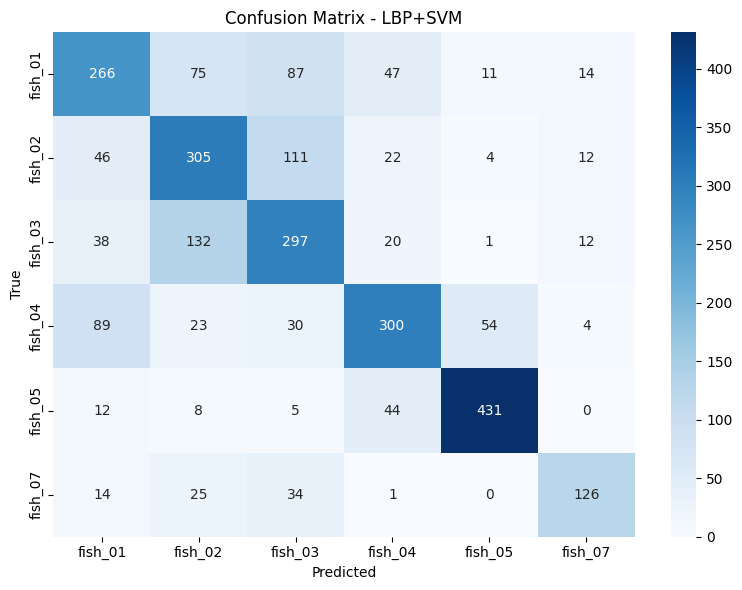

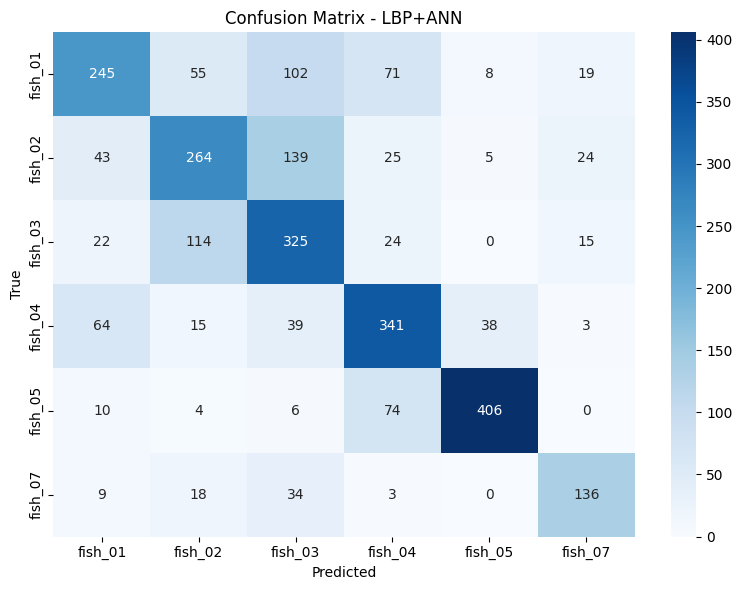

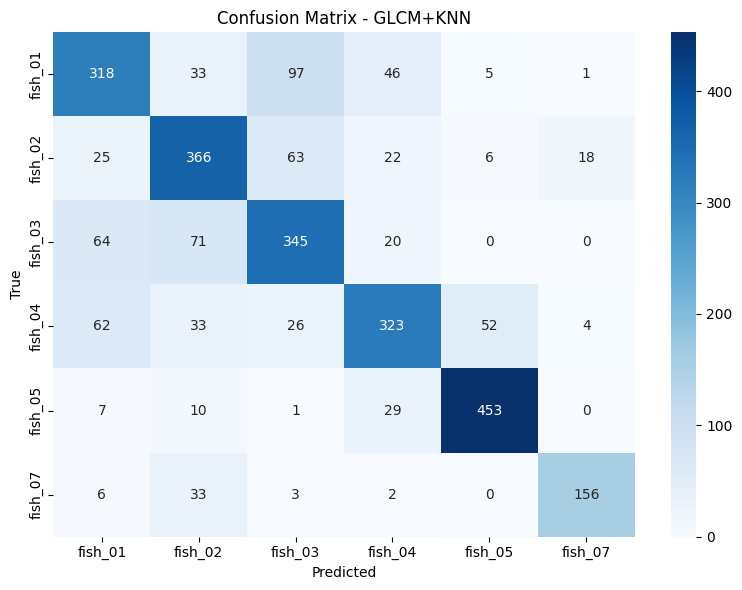

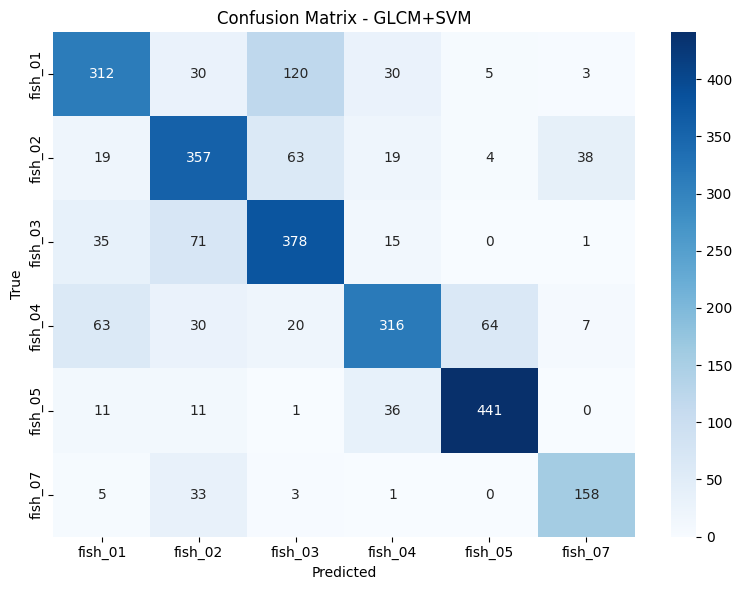

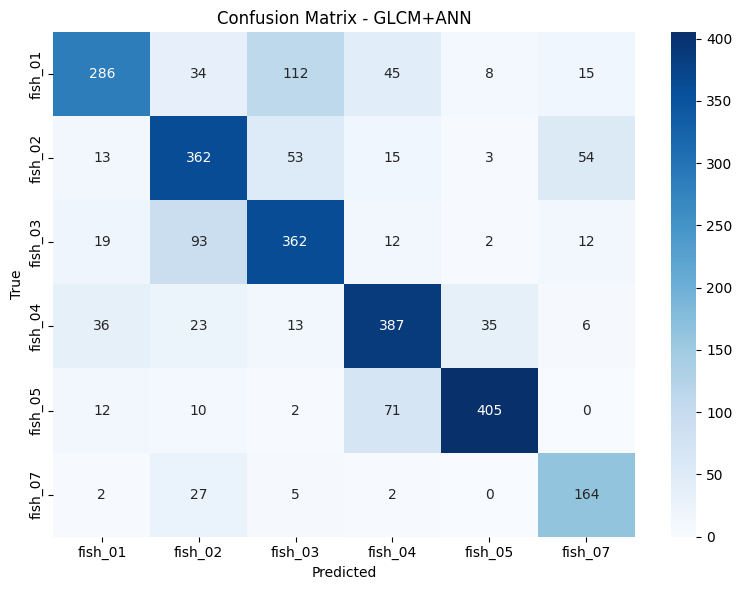

In [22]:
# ============================================
# Cell C: Metrics and Confusion Matrices
# ============================================

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

models_results = {
    "LBP+KNN": y_pred_lbp_knn,
    "LBP+SVM": y_pred_lbp_svm,
    "LBP+ANN": y_pred_lbp_ann,
    "GLCM+KNN": y_pred_glcm_knn,
    "GLCM+SVM": y_pred_glcm_svm,
    "GLCM+ANN": y_pred_glcm_ann
}

rows = []
for name, y_pred in models_results.items():
    acc = accuracy_score(y_test_encoded, y_pred)
    prec = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)

    rows.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

metrics_df = pd.DataFrame(rows)
print("Classification Metrics for All Models:")
print(metrics_df.to_string(index=False))

# -------- Confusion Matrix Plotter --------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

for name, y_pred in models_results.items():
    plot_confusion_matrix(y_test_encoded, y_pred, f"Confusion Matrix - {name}")


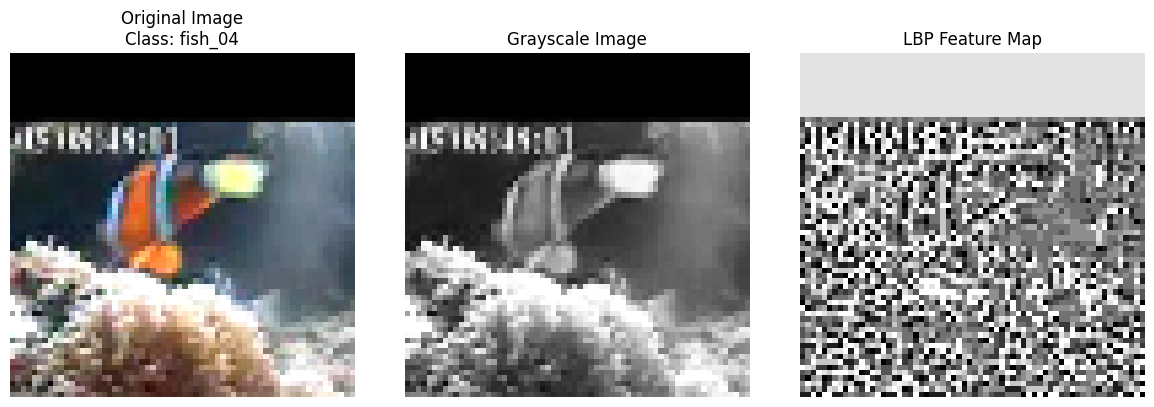

Displayed LBP feature extraction for class: fish_04


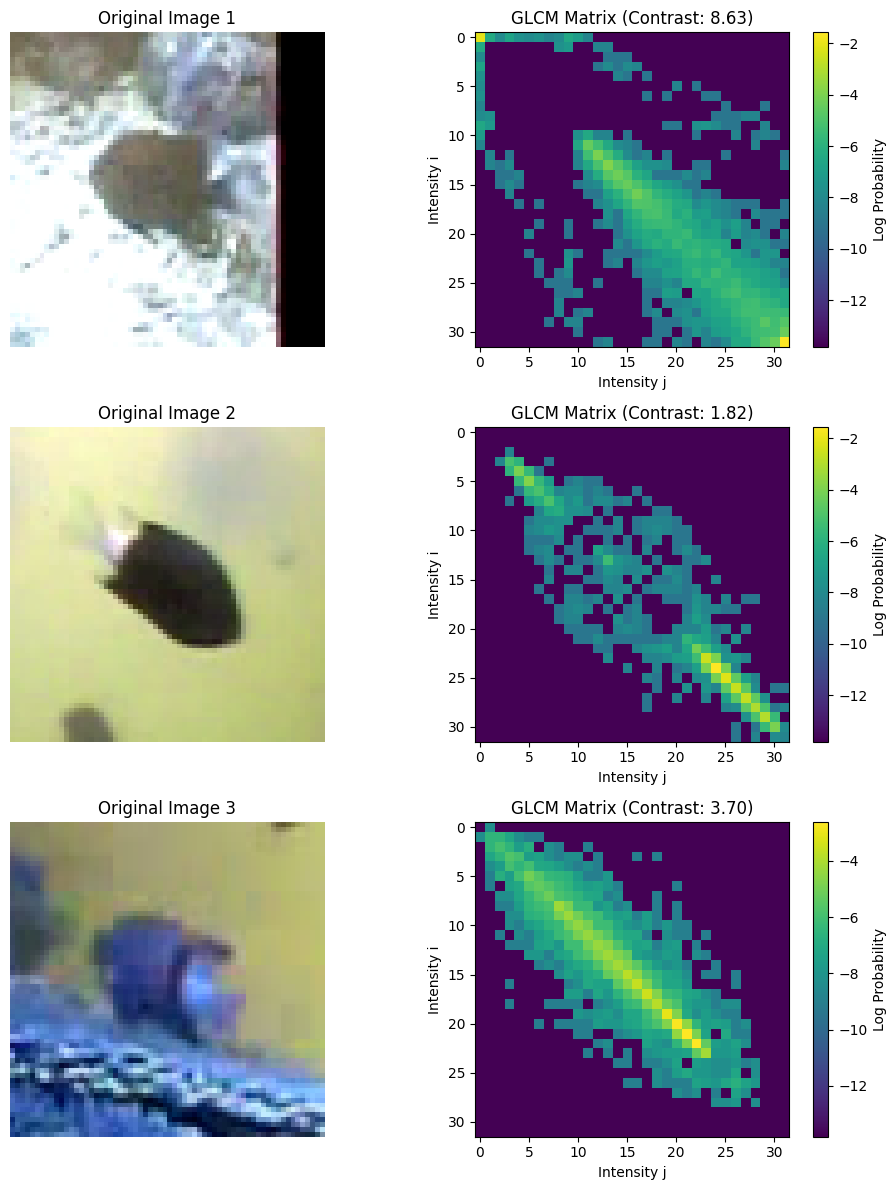

In [23]:
# =========================================
# Cell 4.1: Feature Extraction Visualization
# =========================================
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import cv2

# ===============================
# Part 1 — LBP Visualization
# ===============================

# Select a random sample from the training set
idx = random.randint(0, len(X_train) - 1)
sample_img = X_train[idx]
sample_label = y_train[idx]

# Convert to grayscale
gray_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)

# Compute LBP
lbp_img = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.title(f"Original Image\nClass: {sample_label}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(lbp_img, cmap='gray')
plt.title("LBP Feature Map")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Displayed LBP feature extraction for class: {sample_label}")

# ===============================
# Part 2 — Multi-sample GLCM Visualization (Improved)
# ===============================

def visualize_glcm_samples(images, num=3):
    plt.figure(figsize=(10, num * 4))

    levels = 32
    distances = [1]
    angles = [0]

    for i in range(num):
        img = images[i]

        # Convert to grayscale (0–1)
        if img.ndim == 3:
            gray = rgb2gray(img)
        else:
            gray = img.astype(float) / 255.0

        # Quantize image
        image_q = np.clip(np.round(gray * (levels - 1)), 0, levels - 1).astype(np.uint8)

        # Compute GLCM
        glcm = graycomatrix(
            image_q,
            distances=distances,
            angles=angles,
            levels=levels,
            symmetric=True,
            normed=True
        )

        glcm_mat = glcm[:, :, 0, 0]
        contrast = graycoprops(glcm, 'contrast')[0, 0]

        # Plot original image
        plt.subplot(num, 2, i * 2 + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis("off")

        # Plot GLCM heatmap (log scale)
        plt.subplot(num, 2, i * 2 + 2)
        plt.imshow(np.log(glcm_mat + 1e-6), cmap='viridis')
        plt.title(f"GLCM Matrix (Contrast: {contrast:.2f})")
        plt.xlabel("Intensity j")
        plt.ylabel("Intensity i")
        plt.colorbar(label="Log Probability")

    plt.tight_layout()
    plt.show()

# Run multi-sample visualization
visualize_glcm_samples(X_train, num=3)


In [24]:
# ====================================================
# Classical Models Cross-Validation (LBP + GLCM)
# KNN, SVM, ANN (with saving each fold model)
# ====================================================

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import joblib
import time

# Number of folds
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# -----------------------------
# Helper to run CV for any model
# -----------------------------
def run_cv_and_save(model_name_prefix, build_model_fn, X, y):
    print(f"\n{model_name_prefix}: Cross-validation ({k} folds)")

    fold_accuracies = []
    fold_times = []

    fold = 1
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = build_model_fn()

        start = time.time()
        model.fit(X_tr, y_tr)
        acc = model.score(X_val, y_val)
        duration = time.time() - start

        fold_accuracies.append(acc)
        fold_times.append(duration)

        # Save model
        filename = f"{model_name_prefix.replace(' ', '_').lower()}_fold_{fold}.pkl"
        joblib.dump(model, filename)

        print(f"  Fold {fold}: acc={acc:.4f}, time={duration:.2f}s (saved {filename})")
        fold += 1

    print(f"{model_name_prefix}: mean acc={np.mean(fold_accuracies):.4f}, mean time={np.mean(fold_times):.2f}s")


# ====================================================
# LBP MODELS
# ====================================================

# KNN
run_cv_and_save(
    "LBP KNN",
    lambda: KNeighborsClassifier(n_neighbors=5, metric="euclidean"),
    X_train_lbp_scaled,
    y_train_encoded
)

# SVM
run_cv_and_save(
    "LBP SVM",
    lambda: SVC(kernel="rbf"),
    X_train_lbp_scaled,
    y_train_encoded
)

# ANN (MLP)
run_cv_and_save(
    "LBP ANN",
    lambda: MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, learning_rate_init=0.001),
    X_train_lbp_scaled,
    y_train_encoded
)


# ====================================================
# GLCM MODELS
# ====================================================

# KNN
run_cv_and_save(
    "GLCM KNN",
    lambda: KNeighborsClassifier(n_neighbors=5, metric="euclidean"),
    X_train_glcm_scaled,
    y_train_encoded
)

# SVM
run_cv_and_save(
    "GLCM SVM",
    lambda: SVC(kernel="rbf"),
    X_train_glcm_scaled,
    y_train_encoded
)

# ANN
run_cv_and_save(
    "GLCM ANN",
    lambda: MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, learning_rate_init=0.001),
    X_train_glcm_scaled,
    y_train_encoded
)



LBP KNN: Cross-validation (5 folds)
  Fold 1: acc=0.5875, time=0.09s (saved lbp_knn_fold_1.pkl)
  Fold 2: acc=0.5787, time=0.08s (saved lbp_knn_fold_2.pkl)
  Fold 3: acc=0.5884, time=0.08s (saved lbp_knn_fold_3.pkl)
  Fold 4: acc=0.5810, time=0.08s (saved lbp_knn_fold_4.pkl)
  Fold 5: acc=0.5755, time=0.08s (saved lbp_knn_fold_5.pkl)
LBP KNN: mean acc=0.5822, mean time=0.08s

LBP SVM: Cross-validation (5 folds)
  Fold 1: acc=0.6435, time=2.57s (saved lbp_svm_fold_1.pkl)
  Fold 2: acc=0.6250, time=3.62s (saved lbp_svm_fold_2.pkl)
  Fold 3: acc=0.6181, time=2.54s (saved lbp_svm_fold_3.pkl)
  Fold 4: acc=0.6273, time=2.60s (saved lbp_svm_fold_4.pkl)
  Fold 5: acc=0.6375, time=2.59s (saved lbp_svm_fold_5.pkl)
LBP SVM: mean acc=0.6303, mean time=2.78s

LBP ANN: Cross-validation (5 folds)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 1: acc=0.6431, time=9.17s (saved lbp_ann_fold_1.pkl)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 2: acc=0.6333, time=8.87s (saved lbp_ann_fold_2.pkl)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 3: acc=0.6255, time=8.41s (saved lbp_ann_fold_3.pkl)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 4: acc=0.6190, time=9.22s (saved lbp_ann_fold_4.pkl)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 5: acc=0.6468, time=8.84s (saved lbp_ann_fold_5.pkl)
LBP ANN: mean acc=0.6335, mean time=8.90s

GLCM KNN: Cross-validation (5 folds)
  Fold 1: acc=0.7005, time=0.16s (saved glcm_knn_fold_1.pkl)
  Fold 2: acc=0.6991, time=0.16s (saved glcm_knn_fold_2.pkl)
  Fold 3: acc=0.7042, time=0.16s (saved glcm_knn_fold_3.pkl)
  Fold 4: acc=0.7042, time=0.16s (saved glcm_knn_fold_4.pkl)
  Fold 5: acc=0.7069, time=0.16s (saved glcm_knn_fold_5.pkl)
GLCM KNN: mean acc=0.7030, mean time=0.16s

GLCM SVM: Cross-validation (5 folds)
  Fold 1: acc=0.7190, time=2.81s (saved glcm_svm_fold_1.pkl)
  Fold 2: acc=0.7167, time=2.64s (saved glcm_svm_fold_2.pkl)
  Fold 3: acc=0.7255, time=2.65s (saved glcm_svm_fold_3.pkl)
  Fold 4: acc=0.7042, time=2.66s (saved glcm_svm_fold_4.pkl)
  Fold 5: acc=0.7102, time=3.64s (saved glcm_svm_fold_5.pkl)
GLCM SVM: mean acc=0.7151, mean time=2.88s

GLCM ANN: Cross-validation (5 folds)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 1: acc=0.7806, time=8.26s (saved glcm_ann_fold_1.pkl)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 2: acc=0.7806, time=10.34s (saved glcm_ann_fold_2.pkl)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 3: acc=0.7829, time=9.22s (saved glcm_ann_fold_3.pkl)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 4: acc=0.7657, time=8.03s (saved glcm_ann_fold_4.pkl)
  Fold 5: acc=0.7736, time=9.37s (saved glcm_ann_fold_5.pkl)
GLCM ANN: mean acc=0.7767, mean time=9.04s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


**Cell 5: Train and Evaluate Classical and CNN Models**

In [16]:
# ===============================
# CELL 1: Imports + Safety Check
# ===============================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

# Safety check for required variables
required_vars = ['X_train_cnn', 'X_test_cnn', 'y_train_cnn', 'y_test_cnn', 'y_train_encoded', 'y_test_encoded', 'le']
missing_vars = [v for v in required_vars if v not in globals()]
if missing_vars:
    raise ValueError(f"Missing variables: {missing_vars}. Run dataset preprocessing first.")


In [17]:
# ===============================
# CELL 2: Define CNN Architectures
# ===============================

def build_cnn(dropout=False):
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(64,64,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    if dropout:
        model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    if dropout:
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    if dropout:
        model.add(Dropout(0.5))

    model.add(Dense(len(le.classes_), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [25]:
# ===============================
# CELL 3: Train CNN Without Dropout
# ===============================

models = {}
results = {}
cnn_histories = {}

cnn_no_dropout = build_cnn(dropout=False)
history_no = cnn_no_dropout.fit(
    X_train_cnn, y_train_cnn,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

y_pred_no = np.argmax(cnn_no_dropout.predict(X_test_cnn), axis=1)

models["CNN WO Dropout"] = cnn_no_dropout
results["CNN WO Dropout"] = y_pred_no
cnn_histories["CNN WO Dropout"] = history_no


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8216 - loss: 0.9586 - val_accuracy: 0.3843 - val_loss: 7.3604
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9532 - loss: 0.1518 - val_accuracy: 0.9421 - val_loss: 0.1874
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9744 - loss: 0.0750 - val_accuracy: 0.9046 - val_loss: 0.4895
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9724 - loss: 0.0965 - val_accuracy: 0.8782 - val_loss: 0.5053
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9829 - loss: 0.0504 - val_accuracy: 0.9676 - val_loss: 0.1424
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9921 - loss: 0.0221 - val_accuracy: 0.9144 - val_loss: 0.5707
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9927 - loss: 0.0238 - val_accuracy: 0.9009 - val_loss: 0.4521
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9841 - loss: 0.0684 - val_accuracy: 

In [26]:
# ===============================
# CELL 4: Train CNN With Dropout
# ===============================

cnn_with_dropout = build_cnn(dropout=True)
history_with = cnn_with_dropout.fit(
    X_train_cnn, y_train_cnn,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

y_pred_with = np.argmax(cnn_with_dropout.predict(X_test_cnn), axis=1)

models["CNN W Dropout"] = cnn_with_dropout
results["CNN W Dropout"] = y_pred_with
cnn_histories["CNN W Dropout"] = history_with


Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6983 - loss: 1.5914 - val_accuracy: 0.2528 - val_loss: 23.9453
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8509 - loss: 0.4221 - val_accuracy: 0.8856 - val_loss: 0.7524
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8925 - loss: 0.3177 - val_accuracy: 0.9347 - val_loss: 0.2151
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9139 - loss: 0.2535 - val_accuracy: 0.9556 - val_loss: 0.1281
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9214 - loss: 0.2215 - val_accuracy: 0.9329 - val_loss: 0.2124
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9218 - loss: 0.2334 - val_accuracy: 0.9583 - val_loss: 0.1395
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9442 - loss: 0.1708 - val_accuracy: 0.9458 - val_loss: 0.1631
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9416 - loss: 0.1745 - val_accuracy: 

In [27]:
# ===========================================
# CELL 5: Cross-Validation for CNN Models
# ===========================================
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Convert encoded labels since KFold requires integers not one-hot
y_all_cnn = y_train_encoded
X_all_cnn = X_train_cnn

k = 3  # number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

cv_scores_no_dropout = []
cv_scores_with_dropout = []

fold = 1
for train_idx, val_idx in skf.split(X_all_cnn, y_all_cnn):
    print(f"\nFold {fold}/{k}")

    X_tr, X_val = X_all_cnn[train_idx], X_all_cnn[val_idx]
    y_tr, y_val = to_categorical(y_all_cnn[train_idx]), to_categorical(y_all_cnn[val_idx])

    # -------------------------
    # CNN WITHOUT DROPOUT
    # -------------------------
    cnn_no = build_cnn(dropout=False)
    cnn_no.fit(X_tr, y_tr, epochs=5, batch_size=32, verbose=0)
    score_no = cnn_no.evaluate(X_val, y_val, verbose=0)[1]
    cv_scores_no_dropout.append(score_no)

    # SAVE MODEL FOR THIS FOLD
    cnn_no.save(f"cnn_no_dropout_fold_{fold}.h5")

    # -------------------------
    # CNN WITH DROPOUT
    # -------------------------
    cnn_drop = build_cnn(dropout=True)
    cnn_drop.fit(X_tr, y_tr, epochs=5, batch_size=32, verbose=0)
    score_with = cnn_drop.evaluate(X_val, y_val, verbose=0)[1]
    cv_scores_with_dropout.append(score_with)

    # SAVE MODEL FOR THIS FOLD
    cnn_drop.save(f"cnn_with_dropout_fold_{fold}.h5")

    print(f"Results fold {fold}: WO Dropout={score_no:.4f} | W Dropout={score_with:.4f}")
    fold += 1

print("\nFinal Cross-Validation Accuracy Results:")
print(f"CNN Without Dropout: Mean={np.mean(cv_scores_no_dropout):.4f}, Std={np.std(cv_scores_no_dropout):.4f}")
print(f"CNN With Dropout:    Mean={np.mean(cv_scores_with_dropout):.4f}, Std={np.std(cv_scores_with_dropout):.4f}")



Fold 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results fold 1: WO Dropout=0.9256 | W Dropout=0.9592

Fold 2/3


Results fold 2: WO Dropout=0.9469 | W Dropout=0.9458

Fold 3/3


Results fold 3: WO Dropout=0.9208 | W Dropout=0.9461

Final Cross-Validation Accuracy Results:
CNN Without Dropout: Mean=0.9311, Std=0.0114
CNN With Dropout:    Mean=0.9504, Std=0.0062



 CNN WO Dropout
Accuracy=0.9244, Precision=0.9304, Recall=0.9244


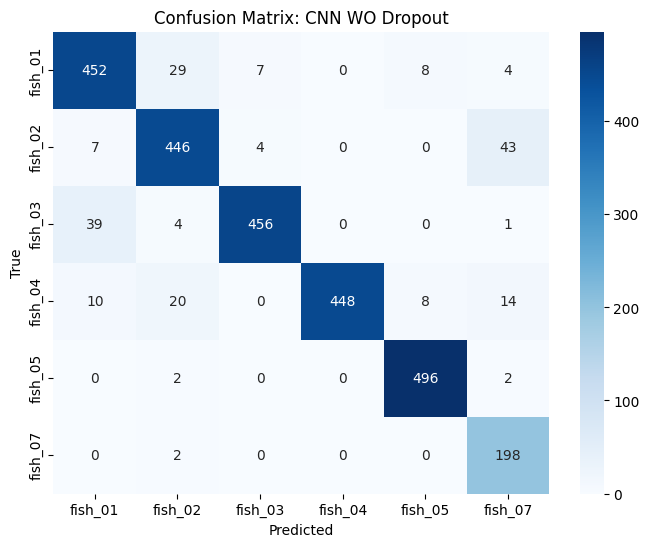


 CNN W Dropout
Accuracy=0.9730, Precision=0.9735, Recall=0.9730


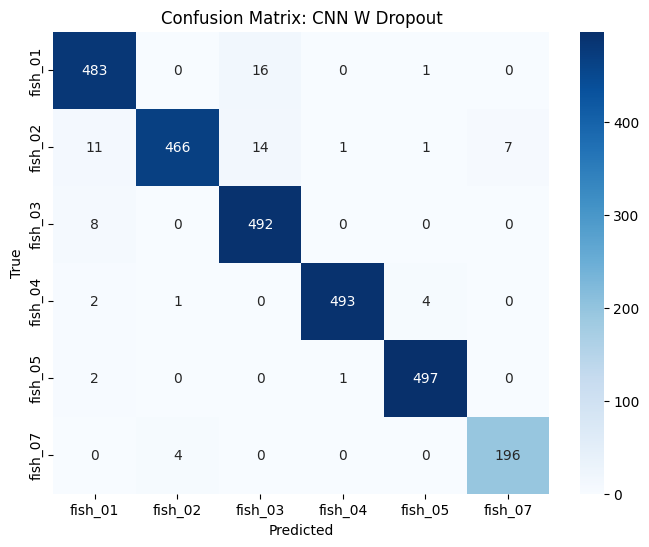

In [28]:
# ===========================================
# CELL 6: Metrics + Confusion Matrices
# ===========================================

def plot_conf_matrix(true, pred, title):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

for name, preds in results.items():
    print("\n", name)
    acc = accuracy_score(y_test_encoded, preds)
    prec = precision_score(y_test_encoded, preds, average='weighted')
    rec = recall_score(y_test_encoded, preds, average='weighted')

    print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}")
    plot_conf_matrix(y_test_encoded, preds, f"Confusion Matrix: {name}")


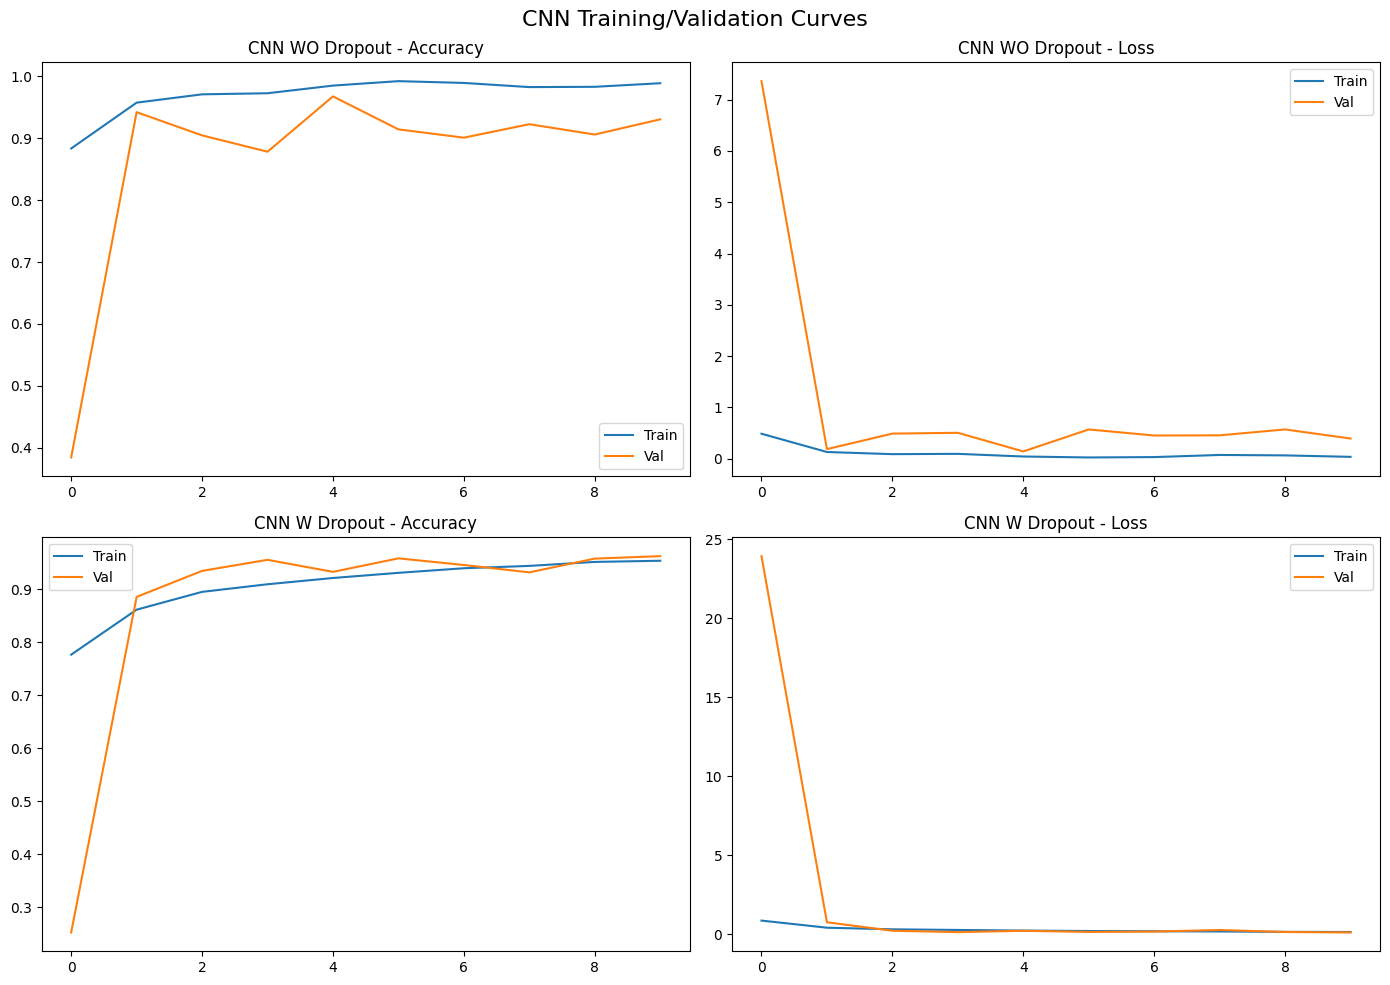

In [29]:
# ===========================================
# CELL 7: Training Curves
# ===========================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("CNN Training/Validation Curves", fontsize=16)

# No dropout - accuracy
axes[0, 0].plot(cnn_histories['CNN WO Dropout'].history['accuracy'])
axes[0, 0].plot(cnn_histories['CNN WO Dropout'].history['val_accuracy'])
axes[0, 0].set_title("CNN WO Dropout - Accuracy")
axes[0, 0].legend(["Train", "Val"])

# No dropout - loss
axes[0, 1].plot(cnn_histories['CNN WO Dropout'].history['loss'])
axes[0, 1].plot(cnn_histories['CNN WO Dropout'].history['val_loss'])
axes[0, 1].set_title("CNN WO Dropout - Loss")
axes[0, 1].legend(["Train", "Val"])

# With dropout - accuracy
axes[1, 0].plot(cnn_histories['CNN W Dropout'].history['accuracy'])
axes[1, 0].plot(cnn_histories['CNN W Dropout'].history['val_accuracy'])
axes[1, 0].set_title("CNN W Dropout - Accuracy")
axes[1, 0].legend(["Train", "Val"])

# With dropout - loss
axes[1, 1].plot(cnn_histories['CNN W Dropout'].history['loss'])
axes[1, 1].plot(cnn_histories['CNN W Dropout'].history['val_loss'])
axes[1, 1].set_title("CNN W Dropout - Loss")
axes[1, 1].legend(["Train", "Val"])

plt.tight_layout()
plt.show()
